### DSI Capstone Project:
# Sentiment Analysis on NTUC Fairprice Mobile App
---
*Esther Leung Sau Yee (GA DSI 16)*

<img src="./images/ntucfp_ec.jpg" width="600">

# Problem Statement

### "How Might We Improve NTUC Fairprice Mobile App User Experience to Boost Online Grocery Sales?"

With the growth in online grocery market, which was further fuelled by Covid-19, NTUC Fairprice needs to **ride the growth the online grocery market** by **identifying negative reviews or sentiments** on the NTUC Fairprice mobile app for **prompt follow up action**, and **improve overall mobile app customer experience** by identifying customers' **pain points** from the mobile app usage.

As such, in this project, I aim to:

1. Build a **classification model** for positive vs. negative reviews
2. Apply **topic modelling** to identify consumers' pain points from negative reviews

## Data Dictionary

The NTUC Fairprice mobile app reviews were extracted from **Google Play Store** and **Apple AppStore**. 

After data cleaning and feature engineering, the data contains the following features:

| Features | Description |
|:--- | :--- |
| date | Date and time of review |
| review | User review on the mobile app |
| rating | User rating on the mobile app (1 to 5, with 5 is highest and 1 is lowest) |
| user | Username |
| source | Source of review (Google Play Store or Apple AppStore) | 
| month | Month of review (value 1 to 12 for Janua
| year | Year of review (between 2015 to 2020) |
| neg_review | Target variable (1 for negative review, 0 for positive review) |
| compound_score | VADER sentiment analyzer compound score (value -1 to 1) |
| pos_score | VADER sentiment analyzer positive score (value 0 to 1) |
| review_lem | User review on the mobile app after Lemmatization |

This project is organised into 2 Jupyter notebooks. In this second notebook **"2_modelling"**, I will focus on:

* [1. Pre-Modelling](#1.-Pre-Modelling)
* [2. Text Classification](#2.-Text-Classification)
* [3. Topic Modelling](#3.-Topic-Modelling)
* [4. Conclusion & Recommendation](#4.-Conclusion-&-Recommendation)

In [1]:
# import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-muted')

# for classifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_auc_score

# for neural network
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Embedding, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

# for topic modelling
import gensim, spacy, logging, warnings
from nltk.corpus import stopwords
import en_core_web_sm
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

%matplotlib inline

In [2]:
# retrieving the data saved after data cleaning and feature engineering
df = pd.read_csv('./data/reviews_for_modelling.csv')

In [3]:
df.head()

,date,review,rating,user,source,month,year,neg_review,compound_score,pos_score,review_lem
0,2020-09-11 13:47:35,Not a good experience for first timer. Login a...,1,Monish Punekar,googleplay,9,2020,1,-0.5358,0.045,good experience first timer login sign problem...
1,2020-07-31 21:04:24,One of the lousiest app! Tried using it severa...,1,yt ng,googleplay,7,2020,1,-0.9258,0.024,one lousiest tried using several time since ma...
2,2020-09-06 08:10:27,Lousy app. Cannot find most items using brand ...,1,Nathanael Lim,googleplay,9,2020,1,-0.4767,0.063,lousy cannot find item using brand name change...
3,2020-06-25 00:07:48,NEW : GETS BETTER AND BETTER - MY LISTS DON'T ...,1,A Google user,googleplay,6,2020,1,0.8797,0.175,new get better better list work shop old impro...
4,2020-07-19 12:43:30,The app would have gotten a 4 stars from me ex...,1,Desmond Tan,googleplay,7,2020,1,-0.2245,0.057,would gotten star except fact thought thru wel...


# 1. Pre-Modelling

The first modelling task at hand is to build a **Text Classification Model** to **identify negative vs. positive reviews** on NTUC Fairprice mobile app.

Before modelling, let's first set up the X and y variables and perform train test split.

In [4]:
# set up X and y
X = df[['review_lem', 'pos_score']]
y = df['neg_review']

In [5]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [6]:
X_train.shape

(2726, 2)

In [7]:
X_test.shape

(909, 2)

In [8]:
y_test.value_counts()

0    465
1    444
Name: neg_review, dtype: int64

In [9]:
y_test.value_counts(normalize=True)

0    0.511551
1    0.488449
Name: neg_review, dtype: float64

The baseline accuracy is the percentage of majority class. In this case, the **baseline accuracy is  0.51**.

It is also noted that there is no imbalance class issue in this data set.

# 2. Text Classification

On of the key objectives of this project is to **classify positive and negative reviews** for NTUC Fairprice app. Specifically, the text classification model should have:
* **High accuracy**
* **High recall**, i.e. predict positive class (Negative Reviews) well so that they can be flagged for follow up 
* **High ROC AUC score**, i.e. the model has strong discrimination capacity to distinguish between positive class and negative class

I will use the following approaches for modelling:
1. Classical Machine Learning approach using text review as feature
2. Classical Machine Learning approach using both text review and VADER positive score as features
3. Deep Learning approach using LSTM

## 2.1 Classical Machine Learning (Text Reviews as Feature)

I will be using a combination of the following:

* Feature extraction using CountVectorizer and TfidfVectorizer
* Classification using Logistic Regression, Multinomial Naive Bayes, and Support Vector Machine

Before I get started, let's first define a function for model evaluation.

In [10]:
# define function for model evaluation
def model_eval(model_name, model, X_test, y_test, y_preds):
    """function to generate classification report,
    plot confusion matrix and ROC curve"""
    print(f"Model           : {model_name}")
    print('----------------------------------------------------------------')
    print(f"best parameters : ")
    print(f"{model.best_params_}")
    print(" ")
    print(f"train accuracy  :  {model.best_score_:.2f}")
    print(" ")
    print(classification_report(y_test, y_preds))
    plot_confusion_matrix(model.best_estimator_, X_test, y_test, cmap='Blues', values_format='d');
    plot_roc_curve(model.best_estimator_, X_test, y_test);

## Model 1a: Logistic Regression with CountVectorizer

In [11]:
# set up pipeline
pipe_lr_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver='lbfgs'))
])

# cross validation using training data
cross_val_score(pipe_lr_cvec, X_train['review_lem'], y_train, cv=5).mean()

0.8352891756561481

In [12]:
pipe_lr_cvec.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('lr', LogisticRegression())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'lr': LogisticRegression(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': None,
 'lr__solver': 'lbfgs',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False}

In [13]:
# set up parameters for gridsearch
pipe_lr_cvec_params = {
    'cvec__max_features': [2000],    # tried [2000, 3000, 4000, 5000]
    'cvec__min_df': [2],             # tried [1, 2]
    'cvec__max_df': [0.9],           # tried [0.9, 0.95, 1.0]
    'cvec__ngram_range': [(1,2)],    # tried [(1,1), (1,2), (2,2)]
    'lr__C': [1.0],                  # tried [1.0, 2.0]
    'lr__max_iter': [100]            # tried [100, 200] 
}

# instantiate gridsearch
gs_lr_cvec = GridSearchCV(pipe_lr_cvec, param_grid = pipe_lr_cvec_params, cv=5)

# fit gridsearch model
gs_lr_cvec.fit(X_train['review_lem'], y_train)

# generate predictions
gs_lr_cvec_y_preds = gs_lr_cvec.best_estimator_.predict(X_test['review_lem'])

Model           : Logistic Regression with CountVectorizer
----------------------------------------------------------------
best parameters : 
{'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'lr__C': 1.0, 'lr__max_iter': 100}
 
train accuracy  :  0.84
 
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       465
           1       0.87      0.83      0.85       444

    accuracy                           0.85       909
   macro avg       0.86      0.85      0.85       909
weighted avg       0.86      0.85      0.85       909



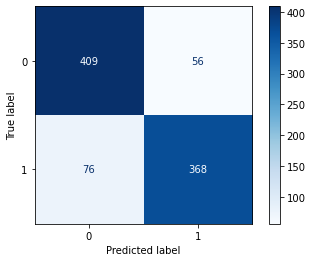

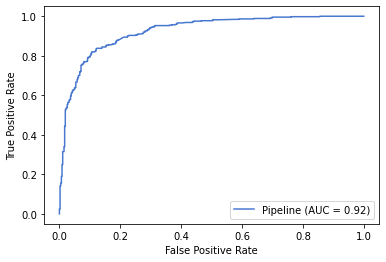

In [14]:
model_eval('Logistic Regression with CountVectorizer', gs_lr_cvec, 
           X_test['review_lem'], y_test, gs_lr_cvec_y_preds)

The **Logistic Regression with CountVectorizer** model has a train accuracy of 0.84 and a **test accuracy of 0.85**. Recall is at 0.83, and the ROC AUC score is 0.92.

In [15]:
lr_cvec_coef = pd.DataFrame(gs_lr_cvec.best_estimator_.named_steps['cvec'].get_feature_names(), columns=['word'])
lr_cvec_coef['exp_coef'] = np.exp(gs_lr_cvec.best_estimator_.named_steps['lr'].coef_[0])

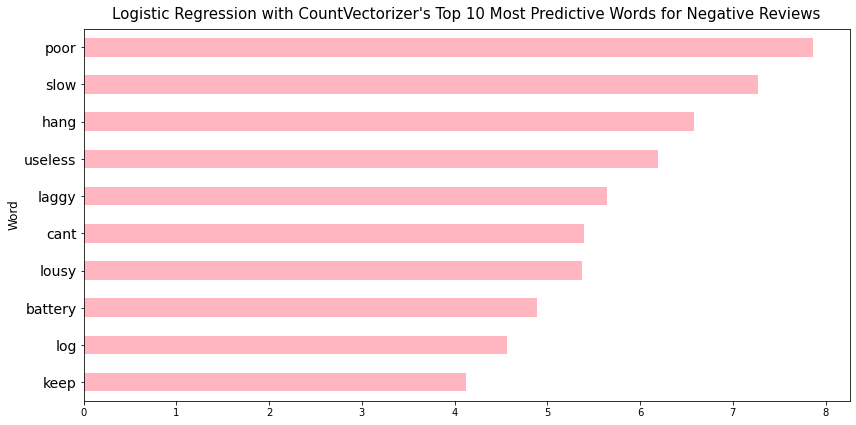

In [16]:
lr_cvec_coef.sort_values(by='exp_coef').tail(10).plot(x='word', y='exp_coef', kind='barh', figsize=(12, 6), legend=None, color='lightpink')
plt.title("Logistic Regression with CountVectorizer's Top 10 Most Predictive Words for Negative Reviews", size=15, y=1.01)
plt.ylabel('Word', size=12)
plt.yticks(size=14)
plt.tight_layout();

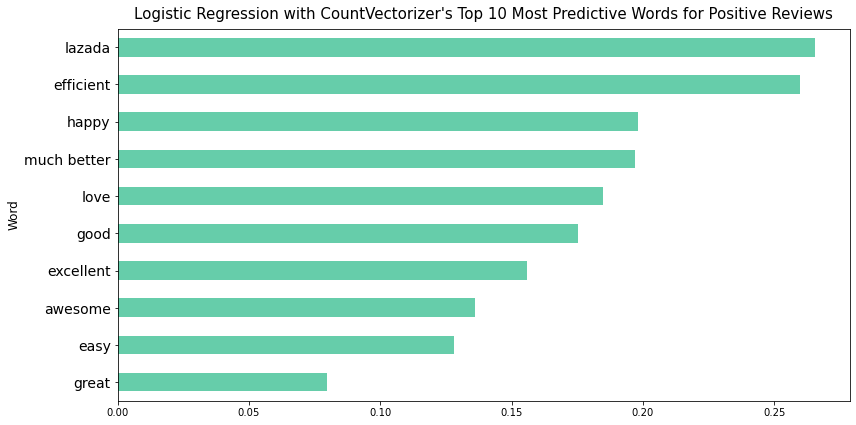

In [17]:
lr_cvec_coef.sort_values(by='exp_coef').head(10).plot(x='word', y='exp_coef', kind='barh', figsize=(12, 6), legend=None, color='mediumaquamarine')
plt.title("Logistic Regression with CountVectorizer's Top 10 Most Predictive Words for Positive Reviews", size=15, y=1.01)
plt.ylabel('Word', size=12)
plt.yticks(size=14)
plt.tight_layout();

In the **Logistic Regression with CountVectorizer** model, the top predictive words are:

* For negative reviews: **'poor', 'slow' and 'hang'**
* For positive reviews: **'lazada', 'efficient', and 'happy'**

## Model 1b: Logistic Regression with TfidfVectorizer

In [18]:
# set up pipeline
pipe_lr_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(solver='lbfgs'))
])

# cross validation using training data
cross_val_score(pipe_lr_tvec, X_train['review_lem'], y_train, cv=5).mean()

0.842254259501966

In [19]:
pipe_lr_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('lr', LogisticRegression())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'lr': LogisticRegression(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state

In [20]:
# set up parameters for gridsearch
pipe_lr_tvec_params = {
    'tvec__max_features': [2000],   # tried [2000, 3000, 4000, 5000]
    'tvec__min_df': [2],            # tried [1, 2]
    'tvec__max_df': [0.9],          # tried [0.9, 0.95, 1.0]
    'tvec__ngram_range': [(1, 1)],  # tried [(1, 1), (1,2), (2,2)]
    'lr__C': [2.0],                 # tried [1.0, 2.0]
    'lr__max_iter': [100]           # tried [100, 200]
}

# instantiate gridsearch
gs_lr_tvec = GridSearchCV(pipe_lr_tvec, param_grid = pipe_lr_tvec_params, cv=5)

# fit gridsearch model
gs_lr_tvec.fit(X_train['review_lem'], y_train)

# generate predictions
gs_lr_tvec_y_preds = gs_lr_tvec.best_estimator_.predict(X_test['review_lem'])

Model           : Logistic Regression with TfidfVectorizer
----------------------------------------------------------------
best parameters : 
{'lr__C': 2.0, 'lr__max_iter': 100, 'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}
 
train accuracy  :  0.85
 
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       465
           1       0.85      0.89      0.87       444

    accuracy                           0.87       909
   macro avg       0.87      0.87      0.87       909
weighted avg       0.87      0.87      0.87       909



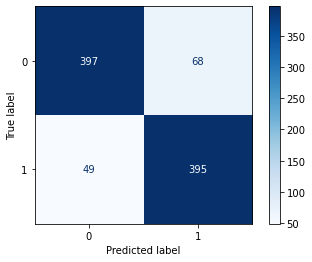

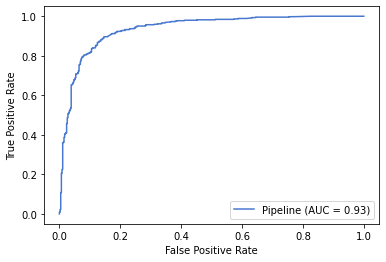

In [21]:
model_eval('Logistic Regression with TfidfVectorizer', gs_lr_tvec, 
           X_test['review_lem'], y_test, gs_lr_tvec_y_preds)

The **Logistic Regression with TfidfVectorizer** has a train accuracy of 0.85 and **test accuracy of 0.87**. Recall and ROC AUC score are higher at 0.89 and 0.93 respectively as compared to Logistic Regression with CountVectorizer. 

In [22]:
lr_tvec_coef = pd.DataFrame(gs_lr_tvec.best_estimator_.named_steps['tvec'].get_feature_names(), columns=['word'])
lr_tvec_coef['exp_coef'] = np.exp(gs_lr_tvec.best_estimator_.named_steps['lr'].coef_[0])

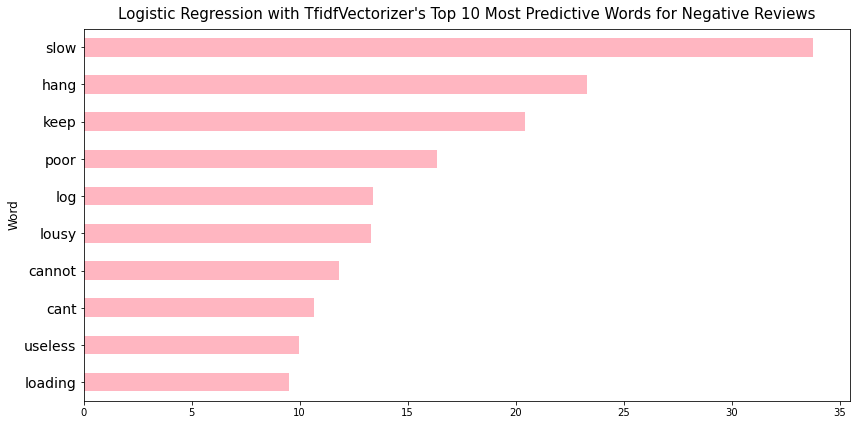

In [23]:
lr_tvec_coef.sort_values(by='exp_coef').tail(10).plot(x='word', y='exp_coef', kind='barh', figsize=(12, 6), legend=None, color='lightpink')
plt.title("Logistic Regression with TfidfVectorizer's Top 10 Most Predictive Words for Negative Reviews", size=15, y=1.01)
plt.ylabel('Word', size=12)
plt.yticks(size=14)
plt.tight_layout();

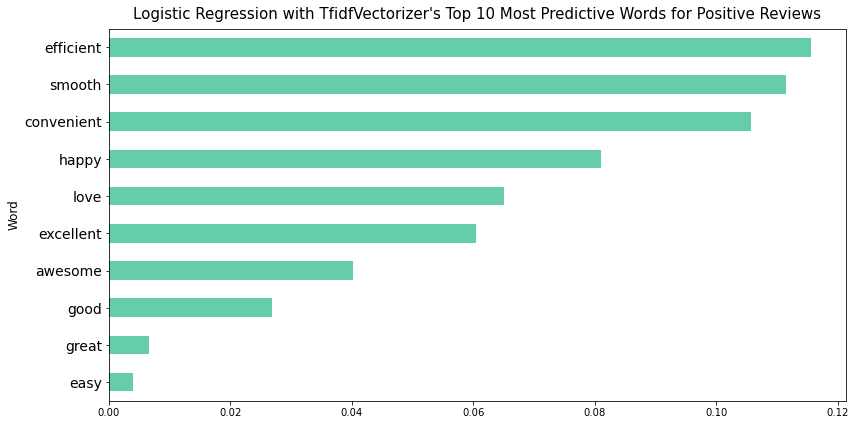

In [24]:
lr_tvec_coef.sort_values(by='exp_coef').head(10).plot(x='word', y='exp_coef', kind='barh', figsize=(12, 6), legend=None, color='mediumaquamarine')
plt.title("Logistic Regression with TfidfVectorizer's Top 10 Most Predictive Words for Positive Reviews", size=15, y=1.01)
plt.ylabel('Word', size=12)
plt.yticks(size=14)
plt.tight_layout();

In the **Logistic Regression with TfidfVectorizer**, the top predictive words are:

* For negative reviews: **'slow', 'hang' and 'keep'**
* For positive reviews: **'efficient', 'smooth', and 'convenient'**

## Model 2a: MultinomialNB with CountVectorizer

In [25]:
# set up pipeline
pipe_nb_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# cross validation using training data
cross_val_score(pipe_nb_cvec, X_train['review_lem'], y_train, cv=5).mean()

0.8378526061094869

In [26]:
pipe_nb_cvec.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [27]:
# set up parameters for gridsearch
pipe_nb_cvec_params = {
    'cvec__max_features': [3000],  # tried [2000, 3000, 4000, 5000]
    'cvec__min_df': [2],           # tried [1, 2]
    'cvec__max_df': [0.9],         # tried [0.9, 0.95, 1.0]
    'cvec__ngram_range': [(1,2)],  # tried [(1,1), (1,2), (2,2)]
    'nb__alpha': [1.0]             # tried [1.0, 1e-1, 1e-2] 
}

# instantiate gridsearch
gs_nb_cvec = GridSearchCV(pipe_nb_cvec, param_grid = pipe_nb_cvec_params, cv=5)

# fit gridsearch model
gs_nb_cvec.fit(X_train['review_lem'], y_train)

# generate predictions
gs_nb_cvec_y_preds = gs_nb_cvec.best_estimator_.predict(X_test['review_lem'])

Model           : MultinomialNB with CountVectorizer
----------------------------------------------------------------
best parameters : 
{'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'nb__alpha': 1.0}
 
train accuracy  :  0.84
 
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       465
           1       0.87      0.86      0.87       444

    accuracy                           0.87       909
   macro avg       0.87      0.87      0.87       909
weighted avg       0.87      0.87      0.87       909



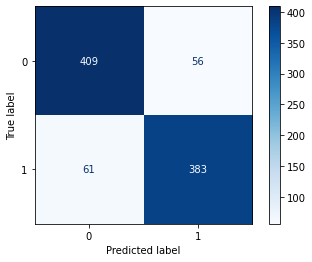

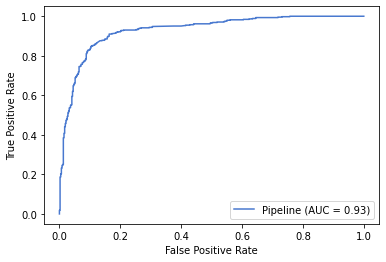

In [28]:
model_eval('MultinomialNB with CountVectorizer', gs_nb_cvec, X_test['review_lem'], y_test, gs_nb_cvec_y_preds)

The **MultinomialNB with CountVectorizer** has a train accuracy of 0.84 and **test accuracy of 0.87**. Recall and ROC AUC score are at 0.86 and 0.93 respectively.

In [29]:
nb_cvec_coef = pd.DataFrame(gs_nb_cvec.best_estimator_.named_steps['cvec'].get_feature_names(), columns=['word'])
nb_cvec_coef['exp_coef'] = np.exp(gs_nb_cvec.best_estimator_.named_steps['nb'].coef_[0])

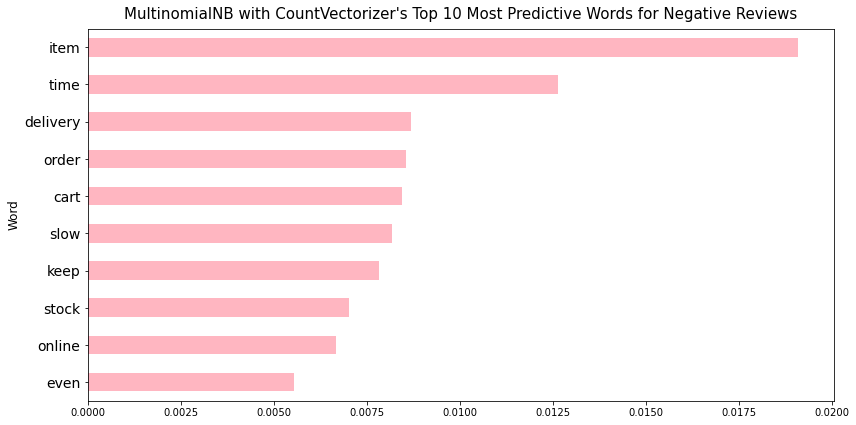

In [30]:
nb_cvec_coef.sort_values(by='exp_coef').tail(10).plot(x='word', y='exp_coef', kind='barh', figsize=(12, 6), legend=None, color='lightpink')
plt.title("MultinomialNB with CountVectorizer's Top 10 Most Predictive Words for Negative Reviews", size=15, y=1.01)
plt.ylabel('Word', size=12)
plt.yticks(size=14)
plt.tight_layout();

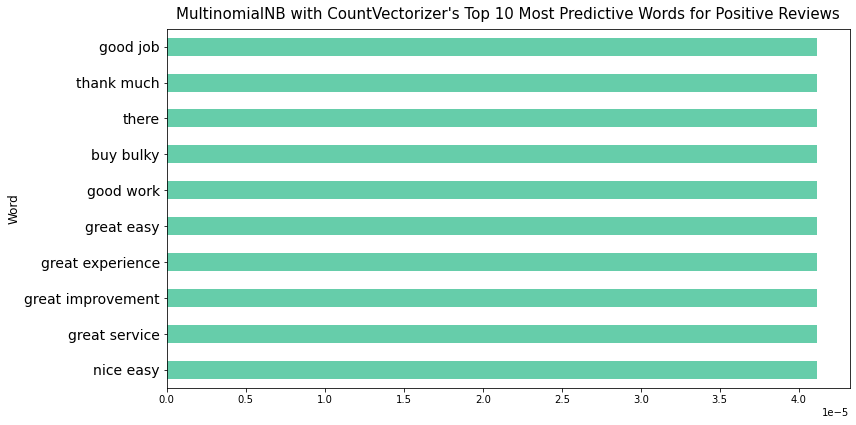

In [31]:
nb_cvec_coef.sort_values(by='exp_coef').head(10).plot(x='word', y='exp_coef', kind='barh', figsize=(12, 6), legend=None, color='mediumaquamarine')
plt.title("MultinomialNB with CountVectorizer's Top 10 Most Predictive Words for Positive Reviews", size=15, y=1.01)
plt.ylabel('Word', size=12)
plt.yticks(size=14)
plt.tight_layout();

In the **MultinomialNB with CountVectorizer**, the top predictive words are:

* For negative reviews: **'item', 'time' and 'delivery'**
* For positive reviews: **'good job', 'thank much', and 'there'**

## Model 2b: MultinomialNB with TfidfVectorizer

In [32]:
# set up pipeline
pipe_nb_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# cross validation using training data
cross_val_score(pipe_nb_tvec, X_train['review_lem'], y_train, cv=5).mean()

0.8451900393184797

In [33]:
pipe_nb_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'nb': MultinomialNB(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [34]:
# set up parameters for gridsearch
pipe_nb_tvec_params = {
    'tvec__max_features': [3000],  # tried [2000, 3000, 4000, 5000]
    'tvec__min_df': [1],           # tried [1, 2]
    'tvec__max_df': [0.9],         # tried [0.9, 0.95, 1.0]
    'tvec__ngram_range': [(1,2)],  # tried [(1, 1), (1,2), (2,2)]
    'nb__alpha': [1.0]             # tried [1.0, 1e-1, 1e-2]
}

# instantiate gridsearch
gs_nb_tvec = GridSearchCV(pipe_nb_tvec, param_grid = pipe_nb_tvec_params, cv=5)

# fit gridsearch model
gs_nb_tvec.fit(X_train['review_lem'], y_train)

# generate predictions
gs_nb_tvec_y_preds = gs_nb_tvec.best_estimator_.predict(X_test['review_lem'])

Model           : MultinomialNB with TfidfVectorizer
----------------------------------------------------------------
best parameters : 
{'nb__alpha': 1.0, 'tvec__max_df': 0.9, 'tvec__max_features': 3000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2)}
 
train accuracy  :  0.85
 
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       465
           1       0.86      0.89      0.87       444

    accuracy                           0.87       909
   macro avg       0.87      0.87      0.87       909
weighted avg       0.87      0.87      0.87       909



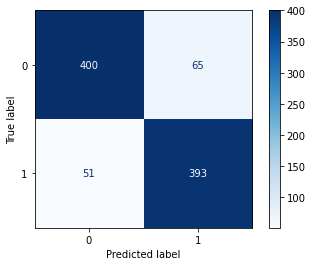

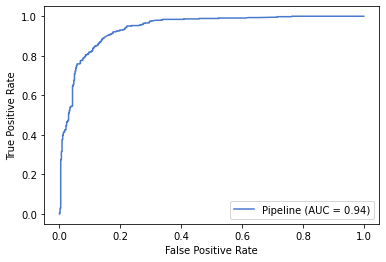

In [35]:
model_eval('MultinomialNB with TfidfVectorizer', gs_nb_tvec, X_test['review_lem'], y_test, gs_nb_tvec_y_preds)

The **MultinomialNB with TfidfVectorizer** has a train accuracy of 0.85 and **test accuracy of 0.87**. Recall and ROC AUC score are high at 0.89 and 0.94 respectively.

In [36]:
nb_tvec_coef = pd.DataFrame(gs_nb_tvec.best_estimator_.named_steps['tvec'].get_feature_names(), columns=['word'])
nb_tvec_coef['exp_coef'] = np.exp(gs_nb_tvec.best_estimator_.named_steps['nb'].coef_[0])

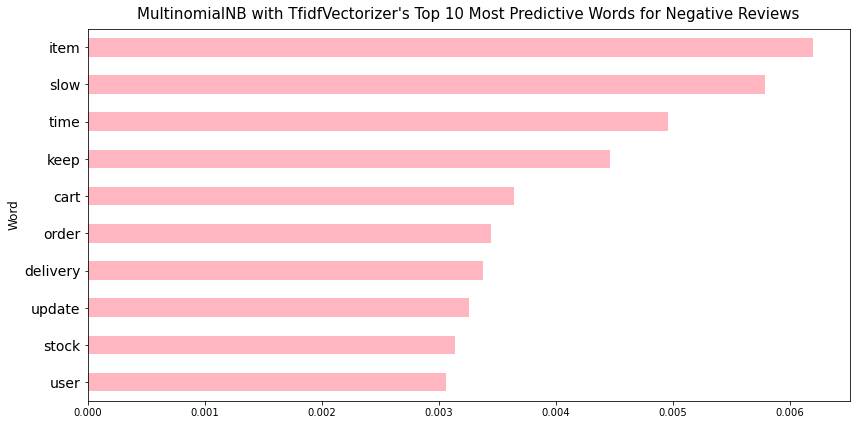

In [37]:
nb_tvec_coef.sort_values(by='exp_coef').tail(10).plot(x='word', y='exp_coef', kind='barh', figsize=(12, 6), legend=None, color='lightpink')
plt.title("MultinomialNB with TfidfVectorizer's Top 10 Most Predictive Words for Negative Reviews", size=15, y=1.01)
plt.ylabel('Word', size=12)
plt.yticks(size=14)
plt.tight_layout();

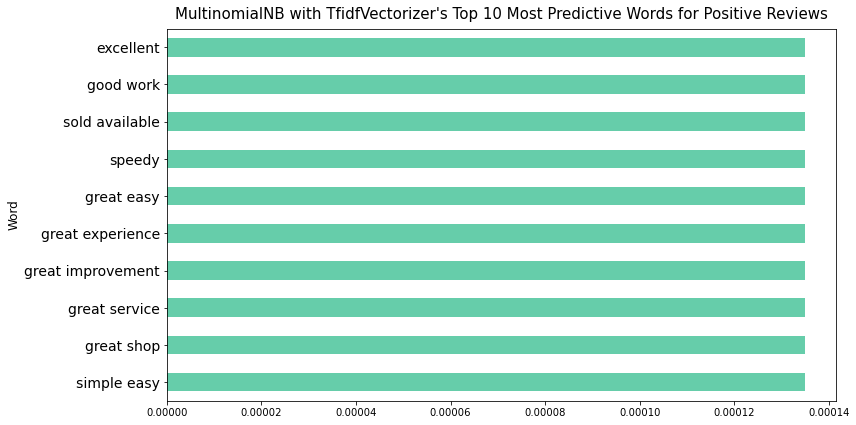

In [38]:
nb_tvec_coef.sort_values(by='exp_coef').head(10).plot(x='word', y='exp_coef', kind='barh', figsize=(12, 6), legend=None, color='mediumaquamarine')
plt.title("MultinomialNB with TfidfVectorizer's Top 10 Most Predictive Words for Positive Reviews", size=15, y=1.01)
plt.ylabel('Word', size=12)
plt.yticks(size=14)
plt.tight_layout();

In the **MultinomialNB with TfidfVectorizer** model, the top predictive words are:

* For negative reviews: **'item', 'slow' and 'time'**
* For positive reviews: **'excellent', 'good work', and 'sold available'**

## Model 3a: SVM with CountVectorizer

In [39]:
# set up pipeline
pipe_svm_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('svm', SVC())
])

# cross validation using training data
cross_val_score(pipe_svm_cvec, X_train['review_lem'], y_train, cv=5).mean()

0.8327217125382264

In [40]:
pipe_svm_cvec.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('svm', SVC())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'svm': SVC(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'svm__C': 1.0,
 'svm__break_ties': False,
 'svm__cache_size': 200,
 'svm__class_weight': None,
 'svm__coef0': 0.0,
 'svm__decision_function_shape': 'ovr',
 'svm__degree': 3,
 'svm__gamma': 'scale',
 'svm__kernel': 'rbf',
 'svm__max_iter': -1,
 'svm__probability': False,
 'svm__random_state': None,
 'svm__shrinking': True,
 'svm__tol': 0.001,
 'svm__verbose': False}

In [41]:
# set up parameters for gridsearch
pipe_svm_cvec_params = {
    'cvec__max_features': [3000],   # tried [2000, 3000, 4000, 5000]
    'cvec__min_df': [1],            # tried [1, 2]
    'cvec__max_df': [0.9],          # tried [0.9, 0.95, 1.0]
    'cvec__ngram_range': [(1, 1)],  # tried [(1,1), (1,2), (2,2)]
    'svm__C': [1.0]                 # tried [1.0, 2.0]
}

# instantiate gridsearch
gs_svm_cvec = GridSearchCV(pipe_svm_cvec, param_grid = pipe_svm_cvec_params, cv=5)

# fit gridsearch model
gs_svm_cvec.fit(X_train['review_lem'], y_train)

# generate predictions
gs_svm_cvec_y_preds = gs_svm_cvec.best_estimator_.predict(X_test['review_lem'])

Model           : SVM with CountVectorizer
----------------------------------------------------------------
best parameters : 
{'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'svm__C': 1.0}
 
train accuracy  :  0.83
 
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       465
           1       0.83      0.85      0.84       444

    accuracy                           0.84       909
   macro avg       0.84      0.84      0.84       909
weighted avg       0.84      0.84      0.84       909



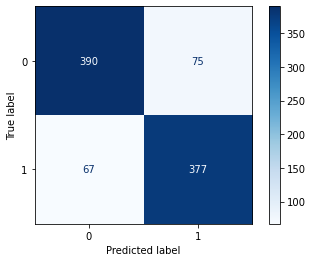

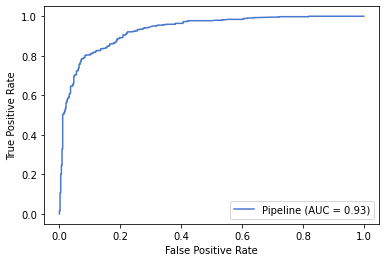

In [42]:
model_eval('SVM with CountVectorizer', gs_svm_cvec, X_test['review_lem'], y_test, gs_svm_cvec_y_preds)

The **Support Vector Machine with CountVectorizer** model performs relatively poorer with train accuracy of 0.83 and test accuracy of 0.84. Recall and ROC AUC score are also relatively lower at 0.85 and 0.93.

## Model 3a: SVM with TfidfVectorizer

In [43]:
# set up pipeline
pipe_svm_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svm', SVC())
])

# cross validation using training data
cross_val_score(pipe_svm_tvec, X_train['review_lem'], y_train, cv=5).mean()

0.8338192694155998

In [44]:
pipe_svm_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('svm', SVC())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'svm': SVC(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'svm__C': 1.0,
 'svm__break_ties': False,
 'svm__cache_size': 200,
 'svm__class_weight': None,
 'svm__coef0': 0.0,
 'svm__decision_function_shape': 'ovr',
 'svm__degree': 3,
 'svm__gamma': 'scale',
 'svm__kernel': 'rbf',
 'svm__max_iter': -1,
 'svm__probability': False,
 'svm__ra

In [45]:
# set up parameters for gridsearch
pipe_svm_tvec_params = {
    'tvec__max_features': [3000],  # tried [2000, 3000, 4000, 5000]
    'tvec__min_df': [2],           # tried [1, 2]
    'tvec__max_df': [0.9],         # tried [0.9, 0.95, 1.0]
    'tvec__ngram_range': [(1,2)],  # tried [(1, 1), (1,2), (2,2)]
    'svm__C': [2.0]                # tried [1.0, 2.0]
}

# instantiate gridsearch
gs_svm_tvec = GridSearchCV(pipe_svm_tvec, param_grid = pipe_svm_tvec_params, cv=5)

# fit gridsearch model
gs_svm_tvec.fit(X_train['review_lem'], y_train)

# generate predictions
gs_svm_tvec_y_preds = gs_svm_tvec.best_estimator_.predict(X_test['review_lem'])

Model           : SVM with TfidfVectorizer
----------------------------------------------------------------
best parameters : 
{'svm__C': 2.0, 'tvec__max_df': 0.9, 'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}
 
train accuracy  :  0.85
 
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       465
           1       0.84      0.89      0.87       444

    accuracy                           0.86       909
   macro avg       0.87      0.87      0.86       909
weighted avg       0.87      0.86      0.86       909



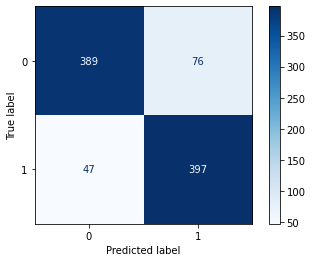

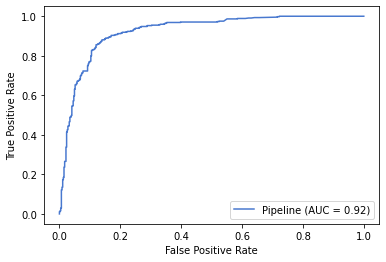

In [46]:
model_eval('SVM with TfidfVectorizer', gs_svm_tvec, X_test['review_lem'], y_test, gs_svm_tvec_y_preds)

The **Support Vector Machine with TfidfVectorizer** model also perform relatively poorer vs. MultinomialNB with train accuracy of 0.85 and test accuracy of 0.86. Recall and ROC AUC score are at 0.89 and 0.92 respectively.

**Model Evaluation:**

| Model | Train Accuracy | Test Accuracy | Recall | Precision | F1 Score | ROC AUC Score |
|:--- |:---:|:---:|:---:|:---:|:---:|:---:|
| Logistic Regression with CountVectorizer | 0.84 | 0.85 | 0.83 | 0.87 | 0.85 | 0.92 |
| Logistic Regression with TfidfVectorizer | 0.85 | 0.87 | 0.89 | 0.85 | 0.87 | 0.93 |
| MultinomialNB with CountVectorizer | 0.84 | 0.87 | 0.86 | 0.87 | 0.87 | 0.93 |
| MultinomialNB with TfidfVectorizer | 0.85 | 0.87 | 0.89 | 0.86 | 0.87 | 0.94 |
| Support Vector Machine with CountVectorizer | 0.83 | 0.84 | 0.85 | 0.83 | 0.84 | 0.93 |
| Support Vector Machine with TfidfVectorizer | 0.85 | 0.86 | 0.89 | 0.84 | 0.87 | 0.92 |

Based on the evaluation metrics:

* Models with features extracted with **TfidfVectorizer** perform slightly better than those with CountVectorizer
* Among the models with features extracted with TfidfVectorizer, the various models perform similarly, but **MutlinomialNB with TfidfVectorizer** performs the best in terms of test accuracy, recall and ROC AUC score, followed by **Logistic Regression with TfidfVectorizer**.

## 2.2 Classical Machine Learning (Text Reviews & VADER Positive Score as Features)

As seen in the EDA, the VADER positive score seems to be correlated to the positive and negative reviews. Let's try to see if using it as a predicter will improve the model performance of the MultinomialNB with TfidfVectorizer model.

First, feature extraction is done using TfidfVectorizer based on the best parameter from earlier gridsearch.

In [47]:
gs_nb_tvec.best_params_

{'nb__alpha': 1.0,
 'tvec__max_df': 0.9,
 'tvec__max_features': 3000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2)}

In [48]:
tvec = TfidfVectorizer(max_features=3000, max_df = 0.9, min_df = 1, ngram_range=(1,2))

In [49]:
X_train_tvec = tvec.fit_transform(X_train['review_lem'])
X_test_tvec = tvec.transform(X_test['review_lem'])

In [50]:
X_train_tvec_df = pd.DataFrame(X_train_tvec.toarray(), columns=tvec.get_feature_names())
X_train_tvec_df.head()

,abit,abit slow,able,able get,able make,able order,able use,absolutely,accept,acceptable,...,wrong item,wrongly,year,year still,yesterday,yet,young,yr,zero,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
X_test_tvec_df = pd.DataFrame(X_test_tvec.toarray(), columns=tvec.get_feature_names())
X_test_tvec_df.head()

,abit,abit slow,able,able get,able make,able order,able use,absolutely,accept,acceptable,...,wrong item,wrongly,year,year still,yesterday,yet,young,yr,zero,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.204812,0.0


Next, the VADER positive score is added as an additional feature.

In [52]:
X_train.reset_index(inplace=True, drop=True)
X_train_tvec_df['pos_score'] = X_train['pos_score']
X_train_tvec_df.head()

,abit,abit slow,able,able get,able make,able order,able use,absolutely,accept,acceptable,...,wrongly,year,year still,yesterday,yet,young,yr,zero,zoom,pos_score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.615
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000


In [53]:
X_test.reset_index(inplace=True, drop=True)
X_test_tvec_df['pos_score'] = X_test['pos_score']
X_test_tvec_df.head()

,abit,abit slow,able,able get,able make,able order,able use,absolutely,accept,acceptable,...,wrongly,year,year still,yesterday,yet,young,yr,zero,zoom,pos_score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.204812,0.0,0.168


Let's proceed to fit the MultinomialNB model with this new feature set.

In [54]:
nb = MultinomialNB(alpha = 1.0)
nb.fit(X_train_tvec_df, y_train)
y_preds = nb.predict(X_test_tvec_df)

MultinomialNB with TfidfVectorizer (with Vader Positive Score as feature)
----------------------------------------------------------------
train accuracy  :  0.91
 
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       465
           1       0.87      0.88      0.87       444

    accuracy                           0.88       909
   macro avg       0.88      0.88      0.88       909
weighted avg       0.88      0.88      0.88       909



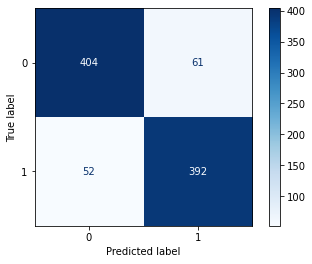

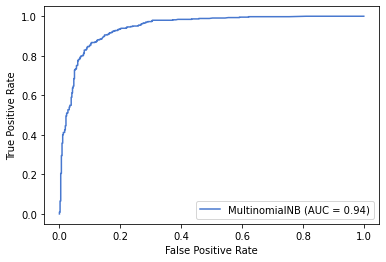

In [55]:
print(f"MultinomialNB with TfidfVectorizer (with Vader Positive Score as feature)")
print('----------------------------------------------------------------')
print(f"train accuracy  :  {nb.score(X_train_tvec_df, y_train):.2f}")
print(" ")
print(classification_report(y_test, y_preds))
plot_confusion_matrix(nb, X_test_tvec_df, y_test, cmap='Blues', values_format='d');
plot_roc_curve(nb, X_test_tvec_df, y_test);

The **MultinomialNB with TfidfVectorizer model with VADER positive score** yield slight improvement to the test accuraccy of 0.88 (over 0.87 without VADER positive score as feature).

In [56]:
nb_coef = pd.Series(np.exp(nb.coef_[0]), index = X_train_tvec_df.columns)

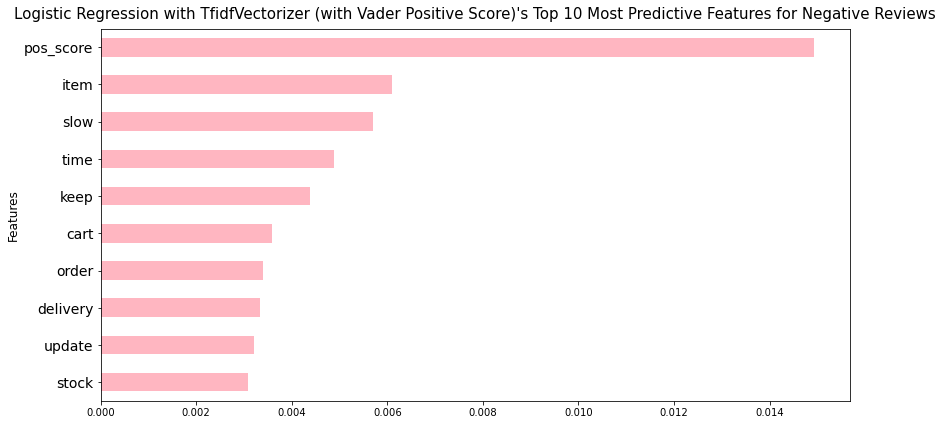

In [57]:
nb_coef.sort_values().tail(10).plot(kind='barh', figsize=(12, 6), legend=None, color='lightpink')
plt.title("Logistic Regression with TfidfVectorizer (with Vader Positive Score)'s Top 10 Most Predictive Features for Negative Reviews", size=15, y=1.01)
plt.ylabel('Features', size=12)
plt.yticks(size=14)
plt.tight_layout();

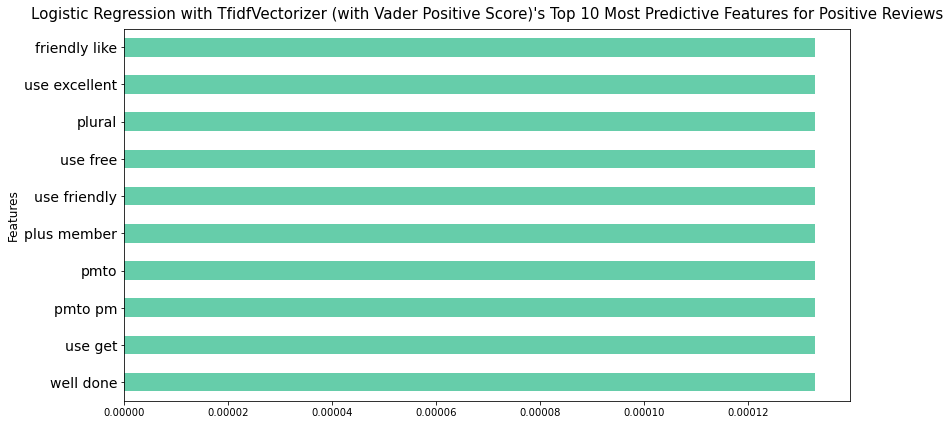

In [58]:
nb_coef.sort_values().head(10).plot(kind='barh', figsize=(12, 6), legend=None, color='mediumaquamarine')
plt.title("Logistic Regression with TfidfVectorizer (with Vader Positive Score)'s Top 10 Most Predictive Features for Positive Reviews", size=15, y=1.01)
plt.ylabel('Features', size=12)
plt.yticks(size=14)
plt.tight_layout();

Notably, the VADER positive score is the top predictor for negative reviews.

**Model Evaluation:**


| Model | Train Accuracy | Test Accuracy | Recall | Precision | F1 Score | ROC AUC Score |
|:--- |:---:|:---:|:---:|:---:|:---:|:---:|
| Logistic Regression with TfidfVectorizer | 0.85 | 0.87 | 0.89 | 0.85 | 0.87 | 0.93 |
| MultinomialNB with TfidfVectorizer | 0.85 | 0.87 | 0.89 | 0.86 | 0.87 | 0.94 |
| MultinomialNB with TfidfVectorizer (with Vader Positive Score as features) | 0.91 | 0.88 | 0.88 | 0.87 | 0.87 | 0.94 |

Comparing the best models from earlier section, **MultinomialNB with TfidfVectorizer using VADER positive score as feature** improves model accuracy marginally, with comparable F1 score and ROC AUC score, while recall dip by 1 percent point.

## 2.3 Ensemble Technique: Voting Classifier

Using the classical machine learning approach with text reviews as feature, the Logistic Regression with TfidfVectorizer and MultinomialNB with TfidfVectorizer give the best results based on test accuracy, recall and ROC AUC score.

Let's build a voting classifier using these 2 models to see if it yield better performance. Soft voting will be used to predict the class based on argmaz of the sums of the predicted probabilities of the 2 estimators, and a higher weight is given to the Multinomial NB as it has slightly better ROC AUC and precision than the Logistic Regression model (while both models have same accuracy and recall).

In [59]:
# instantiate voting classifier
votingcl = VotingClassifier(estimators=[('lr_tvec', gs_lr_tvec), ('nb_tvec', gs_nb_tvec)],
                           voting='soft',    # soft voting predicts the class based on argmax of the sums of the predicted probabilities
                           weights = [1,2])  # higher weight for MultinomialNB as it has higher ROC AUC and precision
                                             # while accuracy and recall are same as logistic regression

# fit voting classifier
votingcl.fit(X_train['review_lem'], y_train)

# generate predictions
voting_y_preds = votingcl.predict(X_test['review_lem'])

Voting Classifier
----------------------------------------------------------------
train accuracy  :  0.92
 
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       465
           1       0.86      0.89      0.88       444

    accuracy                           0.88       909
   macro avg       0.88      0.88      0.88       909
weighted avg       0.88      0.88      0.88       909



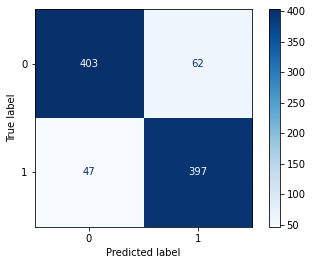

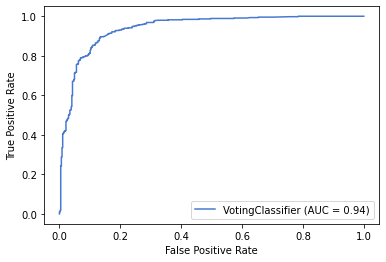

In [60]:
print(f"Voting Classifier")
print('----------------------------------------------------------------')
print(f"train accuracy  :  {votingcl.score(X_train['review_lem'], y_train):.2f}")
print(" ")
print(classification_report(y_test, voting_y_preds))
plot_confusion_matrix(votingcl, X_test['review_lem'], y_test, cmap='Blues', values_format='d');
plot_roc_curve(votingcl, X_test['review_lem'], y_test);

| Model | Train Accuracy | Test Accuracy | Recall | Precision | F1 Score | ROC AUC Score |
|:--- |:---:|:---:|:---:|:---:|:---:|:---:|
| Logistic Regression with TfidfVectorizer | 0.85 | 0.87 | 0.89 | 0.85 | 0.87 | 0.93 |
| MultinomialNB with TfidfVectorizer | 0.85 | 0.87 | 0.89 | 0.86 | 0.87 | 0.94 |
| MultinomialNB with TfidfVectorizer (with Vader Positive Score as feature) | 0.91 | 0.88 | 0.88 | 0.87 | 0.87 | 0.94 |
| Voting Classifier (Logistic Regression & Multinomial NB with TfidfVectorizer)| 0.92 | 0.88 | 0.89 | 0.86 | 0.88 | 0.94| 


The **Voting Classifer** model achieves a comparable test accuracy of 0.88 and ROC AUC score of 0.94 vs. the MultinomialNB with TfidfVectorizer model using VADER positive score as feature. Recall has improved by 1 percent point to 0.89.

## 2.4 Deep Learning using LSTM

Finally, I will attempt to apply Deep Learning for this classification problem. 

I will be using Recurrent Neural Network (RNN), specifically Long Short Term Memory (LSTM) for modelling. LSTM was introduced by Hocheriter & Schmindhuber in 1997. It is a type of RNN network that can grasp long term dependence.

To implement LSTM, I will first prepare the data by:
* Putting the reviews in an array
* Tokenize the reviews
* Transform the reviews into sequences
* Padding the sequences to have equal length

In [61]:
X_train_ls = X_train['review_lem'].values
X_test_ls = X_test['review_lem'].values

y_train_ls = y_train.values
y_test_ls = y_test.values

In [62]:
X_train_ls

array(['good service', 'good', 'add staff upper boon keng rd outlet', ...,
       'previous convenience lost remove cart add list many others',
       'slow poor ux page load slowly system glitch often trying check',
       'hang easily'], dtype=object)

In [63]:
max_words = 1000    # set to 1000 for now; check for overfitting

# Tokenize 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(X_train_ls))

# Convert to sequences
X_train_ls = tokenizer.texts_to_sequences(X_train_ls)
X_test_ls = tokenizer.texts_to_sequences(X_test_ls)

In [64]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

3257

In [65]:
max_length = 15 

# add padding so the length of each sequence is 15 words
X_train_pad = pad_sequences(X_train_ls, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_ls, maxlen=max_length, padding='post')

Now that the data are converted into sequences, let's proceed to set up the LSTM model and fit the model.

In [66]:
# Instantiate model
model = Sequential()

# first embedding layer
model.add(Embedding(vocab_size, 8, input_length=max_length)) 

# drop out
model.add(SpatialDropout1D(0.5))

# LSTM layer
model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))) 

# output layer
model.add(Dense(1, activation='sigmoid'))

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 8)             26056     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 15, 8)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 32)            3200      
_________________________________________________________________
dense (Dense)                (None, 15, 1)             33        
Total params: 29,289
Trainable params: 29,289
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Compile the model
model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
# create checkpoint to save weights
filepath='./output/weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [70]:
# fit the model
history = model.fit(X_train_pad, y_train_ls, epochs=15, batch_size=64, 
                    validation_data=(X_test_pad, y_test_ls), callbacks = callbacks_list)

Epoch 1/15
41/43 [===========================>..] - ETA: 0s - loss: 0.6231 - accuracy: 0.6383
Epoch 00001: val_accuracy improved from -inf to 0.82838, saving model to ./output\weights.best.hdf5
43/43 [==============================] - 1s 26ms/step - loss: 0.6197 - accuracy: 0.6425 - val_loss: 0.4464 - val_accuracy: 0.8284
Epoch 2/15
43/43 [==============================] - ETA: 0s - loss: 0.4626 - accuracy: 0.8073
Epoch 00002: val_accuracy improved from 0.82838 to 0.84811, saving model to ./output\weights.best.hdf5
43/43 [==============================] - 1s 14ms/step - loss: 0.4626 - accuracy: 0.8073 - val_loss: 0.3886 - val_accuracy: 0.8481
Epoch 3/15
43/43 [==============================] - ETA: 0s - loss: 0.4024 - accuracy: 0.8407
Epoch 00003: val_accuracy improved from 0.84811 to 0.85941, saving model to ./output\weights.best.hdf5
43/43 [==============================] - 1s 19ms/step - loss: 0.4024 - accuracy: 0.8407 - val_loss: 0.3545 - val_accuracy: 0.8594
Epoch 4/15
40/43 [====

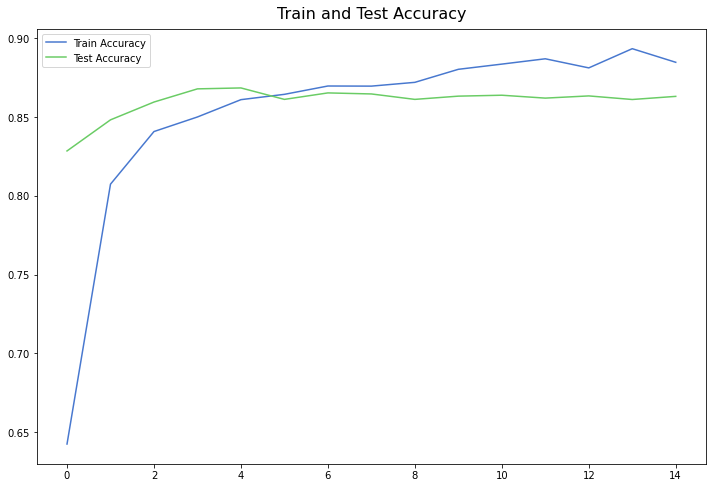

In [71]:
plt.figure(figsize=(10,6))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title("Train and Test Accuracy", fontsize=16, y=1.01)
plt.legend();

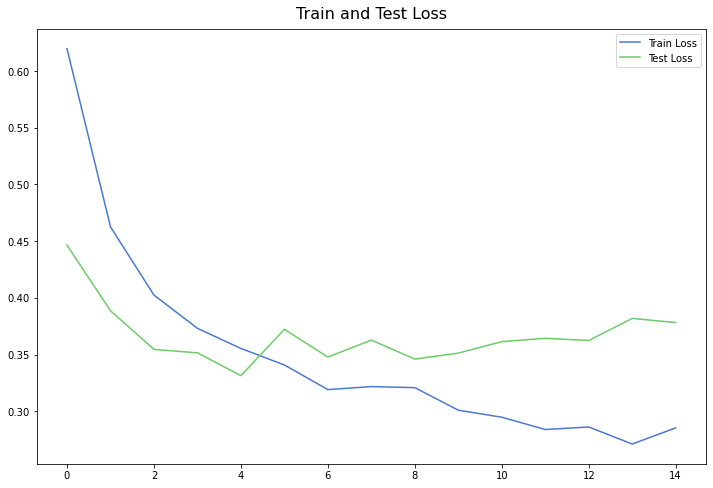

In [72]:
plt.figure(figsize=(10,6))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title("Train and Test Loss", fontsize=16, y=1.01)
plt.legend();

### Loading a Check-Pointed LSTM Model

In [73]:
# load the weights
model.load_weights('./output/weights.best.hdf5')

In [74]:
# compile the model
model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy', metrics=['accuracy'])

In [75]:
# obtain y_preds
preds = (model.predict(X_test_pad) > 0.5).astype(int)

y_preds = []

for i in preds:
    y_preds.append(i[0][0])

# Convert y_preds to a series
lstm_y_preds = pd.Series(y_preds)

In [76]:
# obtain y_preds_proba
preds_probas = model.predict(X_test_pad)

y_preds_probas = []

for i in preds_probas:
    y_preds_probas.append(i[0][0])

# Convert y_preds_probas to a series
lstm_y_preds_probas = pd.Series(y_preds_probas)

In [77]:
print(f"Neural Network - LSTM Model")
print('----------------------------------------------------------------')
print(f"train accuracy  :  {model.evaluate(X_train_pad, y_train_ls, verbose=0)[1]:.2f}")
print(" ")
print(classification_report(y_test_ls, lstm_y_preds))
print(f"ROC AUC Score  :  {roc_auc_score(y_test_ls, lstm_y_preds_probas):.2f}")

Neural Network - LSTM Model
----------------------------------------------------------------
train accuracy  :  0.91
 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       465
           1       0.87      0.87      0.87       444

    accuracy                           0.88       909
   macro avg       0.88      0.88      0.88       909
weighted avg       0.88      0.88      0.88       909

ROC AUC Score  :  0.94


In the **LSTM model**, the test accuracy is 0.88, similar to the classical machine learning models.

| Model | Train Accuracy | Test Accuracy | Recall | Precision | F1 Score | ROC AUC Score |
|:--- |:---:|:---:|:---:|:---:|:---:|:---:|
| Logistic Regression with TfidfVectorizer | 0.85 | 0.87 | 0.89 | 0.85 | 0.87 | 0.93 |
| MultinomialNB with TfidfVectorizer | 0.85 | 0.87 | 0.89 | 0.86 | 0.87 | 0.94 |
| MultinomialNB with TfidfVectorizer (with Vader Positive Score as feature) | 0.91 | 0.88 | 0.88 | 0.87 | 0.87 | 0.94 |
| Voting Classifier (Logistic Regression & Multinomial NB with TfidfVectorizer)| 0.92 | 0.88 | 0.89 | 0.86 | 0.88 | 0.94| 
| LSTM Model | 0.90 | 0.88 | 0.85 | 0.89 | 0.87 | 0.94 |

After evaluating all the models, the **Voting Classifier** is selected as the production model, given its relatively better test accuracy, recall, F1 score and ROC AUC score.

## 2.5 Review on Misclassified Reviews

Let's take a look at the Voting Classifier model and review the misclassified reviews.

In [78]:
# create a dataframe for only the test data
test_df = df.loc[y_test.index, :] 

# add a column for predictions
test_df['pred'] = voting_y_preds

In [79]:
# create a dataframe of misclassified reviews
misclassified_df = test_df[test_df['neg_review'] != test_df['pred']]

In [80]:
misclassified_df.shape

(109, 12)

There are a total of 109 misclassified posts (out of 909 reviews).

### 2.5.1 False Positives

Recall that the positive class refers to the Negative Posts, and positive class refers to Positive Posts.

First, let's look at the False Positives, which are the Negative Reviews wrongly classified as Positive Reviews.

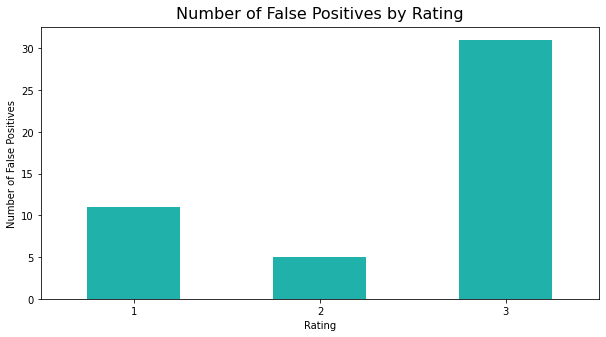

In [81]:
plt.figure(figsize=(10, 5))
misclassified_df[(misclassified_df['neg_review'] == 1) & (misclassified_df['pred'] == 0)]['rating'].value_counts().sort_index().plot(kind='bar', color='lightseagreen')
plt.title('Number of False Positives by Rating', fontsize=16, y=1.01)
plt.ylabel('Number of False Positives')
plt.xlabel('Rating')
plt.xticks(rotation=0);

In [82]:
pd.set_option('display.max_colwidth', None)
misclassified_df[(misclassified_df['neg_review'] == 1) & (misclassified_df['pred'] == 0) & (misclassified_df['rating'] == 3)][['review', 'neg_review', 'rating', 'pred']].head(10)

,review,neg_review,rating,pred
1043,not as easy as I thought,1,3,0
1000,Will be good to maintain a list of my regular purchased items,1,3,0
1033,There is no function to offset against linkpoints if you are ntuc member.,1,3,0
1230,K,1,3,0
963,Helpful if able to show how much more to purchase to enjoy free delivery instead of flashing few seconds. Thanks,1,3,0
1035,app better than on computer,1,3,0
1125,user friendly as can order on the go but can be better if screen can load more products to view at a glance. best if intelligent s/w can help propose related products to make online shopping easier.,1,3,0
951,The product required are running low on stock. It will be good to have option to update when stock will be replenished. Preferably will be good to catered online chat assistance for urgent enquiries.,1,3,0
3093,Just Suggestion The app is useful but I think it would be better if we can receive promotion notification on the items we selected.,1,3,0
3069,Not easy to navigate Once you click on a product it’s not easy to go back to the cart or to home. You can’t find the back arrow or anywhere to click to go back!,1,3,0


Notably, many of the misclassified False Positives are actually 'neutral' reviews with rating 3 out of 5, with suggestions for improvement.

### 2.5.2 False Negatives

The False Negatives are Positive Reviews being misclassified as Negative Reviews.

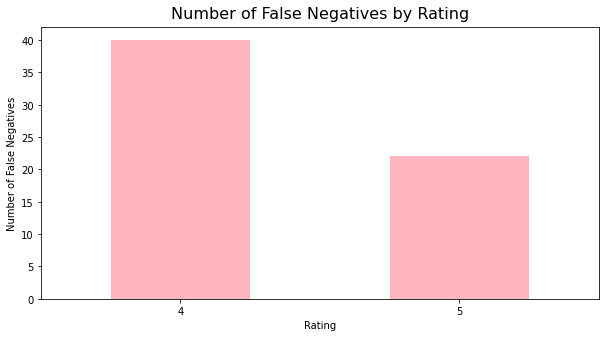

In [83]:
plt.figure(figsize=(10, 5))
misclassified_df[(misclassified_df['neg_review'] == 0) & (misclassified_df['pred'] == 1)]['rating'].value_counts().sort_index().plot(kind='bar', color='lightpink')
plt.title('Number of False Negatives by Rating', fontsize=16, y=1.01)
plt.ylabel('Number of False Negatives')
plt.xlabel('Rating')
plt.xticks(rotation=0);

In [84]:
misclassified_df[(misclassified_df['neg_review'] == 0) & (misclassified_df['pred'] == 1) & (misclassified_df['rating'] == 4)][['review', 'neg_review', 'rating', 'pred']].head(10)

,review,neg_review,rating,pred
1268,"I've been using this app for a few months because it's very convenient. It's genrally user-friendly, great filter and search functions, good pictures and descriptions. However, it's slow to update the number of units, so I've received the wrong number of the same item a few times. On one occasion, I received the wrong fresh produce (presumably another customer's order). Tried customer service, but I didn't receive a reply.",0,4,1
3005,Service better but can be better A lot of items found in physical store not available here. Don’t why. Like kong guan pau never available online but always available in physical store wondering why?,0,4,1
3237,Membership inclusion Doesn’t seem to,0,4,1
1259,"Similar to shopping on site, previously its hard to get delivery slot, now looks like better",0,4,1
1537,okay but items outbof stock,0,4,1
1708,More friendly use & nice appearance. But I have to log in many times when I continue my shopping list.,0,4,1
3097,Delivery Timing May be can consider a more narrow time frame for delivery. 1 hour range instead of 2 hours. Overall the app is fine,0,4,1
1488,always out of stock 🤦‍♀️,0,4,1
1393,good app just abit slow to remove item from cart,0,4,1
1258,"In beginning of cb period is very hard to get delivery slot. And your orders is always being modified on the day of delivery due to out of stock. If buy for stock up, it is good apps. If buy for urgent use, pls forget this apps.",0,4,1


Among the False Negatives, there are more reviews with rating 4. Among these misclassified reviews, some are mixed reviews with generally good feedback but some negative comments, like the following example.

In [85]:
misclassified_df.loc[1268, 'review']

"I've been using this app for a few months because it's very convenient. It's genrally user-friendly, great filter and search functions, good pictures and descriptions. However, it's slow to update the number of units, so I've received the wrong number of the same item a few times. On one occasion, I received the wrong fresh produce (presumably another customer's order). Tried customer service, but I didn't receive a reply."

# 3. Topic Modelling

To address the second project objective to identify customers' pain points for continuous customer experience improvement, I will perform a topic modelling on the negative reviews to see which are the topics that emerge.

Topic modelling is an unsupervised approach used for finding and observing the bunch of words (called “topics”) in large clusters of texts.

I will be applying Latent Dirichlet Allocation (LDA). LDA assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. Given a dataset of documents, LDA backtracks and tries to figure out what topics would create those documents in the first place.

In [86]:
# extracting only negative reviews
data = df[df['neg_review'] == 1]['review'].values.tolist()

Before building the model, let's preprocess the negative reviews to:
* Remove stopwords
* Form bigrams and trigrams
* Lemmatize the words

In [87]:
# set up a set of stopwords
stops = set(stopwords.words('english'))
stops.update(['app', 'apps', 'application', 'ntuc','fairprice']) 

In [88]:
# build the bigram and trigram models
bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [89]:
# define a function to process words
def process_words(texts, stop_words=stops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stops] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stops] for doc in texts_out]    
    return texts_out

In [90]:
# preprocessing negative reviews
data_ready = process_words(data)  

In [91]:
# check the number of reviews after preprocessing
len(data_ready)

1775

Now that the reviews have been preprocessed, let's proceed to build a LDA model.

I have tried different number of topics, and the following model with 3 topics make most business sense in the EDA that follows.

In [92]:
# create dictionary
neg_id2word = corpora.Dictionary(data_ready)

# create corpus: term document frequency
neg_corpus = [neg_id2word.doc2bow(text) for text in data_ready]

# build LDA model of 3 topics
neg_lda_model = gensim.models.ldamodel.LdaModel(corpus=neg_corpus,
                                           id2word=neg_id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(neg_lda_model.print_topics())

[(0,
  '0.023*"time" + 0.022*"use" + 0.022*"keep" + 0.021*"even" + 0.019*"card" + '
  '0.018*"hang" + 0.017*"payment" + 0.017*"update" + 0.016*"unable" + '
  '0.014*"code"'),
 (1,
  '0.029*"item" + 0.029*"delivery" + 0.025*"online" + 0.023*"stock" + '
  '0.018*"order" + 0.015*"purchase" + 0.013*"time" + 0.012*"point" + '
  '0.011*"redmart" + 0.011*"available"'),
 (2,
  '0.052*"slow" + 0.033*"item" + 0.025*"cart" + 0.020*"user" + 0.019*"crash" + '
  '0.018*"take" + 0.018*"search" + 0.017*"time" + 0.016*"load" + '
  '0.015*"update"')]


In [93]:
# define a function to show the topic for each document
def format_topics_sentences(ldamodel=None, corpus=None, texts=data):
    # init output
    sent_topics_df = pd.DataFrame()

    # get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [94]:
neg_df_topic_sents_keywords = format_topics_sentences(ldamodel=neg_lda_model, corpus=neg_corpus, texts=data_ready)

# format the dataframe
neg_df_dominant_topic = neg_df_topic_sents_keywords.reset_index()
neg_df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
neg_df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.5907,"time, use, keep, even, card, hang, payment, update, unable, code","[good, experience, sign, problem, enter, detail, prompt, delivery, date, available, first, step, instead, last]"
1,1,1.0,0.4806,"item, delivery, online, stock, order, purchase, time, point, redmart, available","[lousiest, try, use, several, time, may, never, complete, transaction, reason, may, always, say, slot, time, slot, many, item, cart, become, stock, point, pay, delivery, fee, half, fill, cart, try, use, utilise, promo, code, keep, say, finally, get, accept, item, become, stock, irritating]"
2,2,2.0,0.5391,"slow, item, cart, user, crash, take, search, time, load, update","[lousy, find, item, use, brand, name, change, use, scanning, totally, disable, label, function, store, detect, slow, unstable, online, grocery, far, well]"
3,3,2.0,0.7094,"slow, item, cart, user, crash, take, search, time, load, update","[new, get, well, well, list, work, shop, old, improve, significantly, last, year, still, miss, want, order, give, quick, access, shopping, list, allow, sort, filter, favourite, shopping, list, make, inefficient, slow, shop, product, wise, consistently, rotten, fruit, vegetable]"
4,4,1.0,0.9649,"item, delivery, online, stock, order, purchase, time, point, redmart, available","[would, get, star, fact, think, well, enough, purchase, eligible, bonus, point, consumer, need, redemption, quite, disappointment, basic, feature, include]"


In [95]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

neg_sent_topics_sorteddf_mallet = pd.DataFrame()
neg_sent_topics_outdf_grpd = neg_df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in neg_sent_topics_outdf_grpd:
    neg_sent_topics_sorteddf_mallet = pd.concat([neg_sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
neg_sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
neg_sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
neg_sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9736,"time, use, keep, even, card, hang, payment, update, unable, code","[always, close, try, input, promo, code, want, give, discount, need, set, bug, shut, whenever, w..."
1,1.0,0.9858,"item, delivery, online, stock, order, purchase, time, point, redmart, available","[bother, delivery, well, redmart, honestbee, bad, experience, fp, use, service, mth, miss, item,..."
2,2.0,0.9684,"slow, item, cart, user, crash, take, search, time, load, update","[slow, last, update, become, super, slow, opening, cart, take, min, update, cart, take, minute, ..."


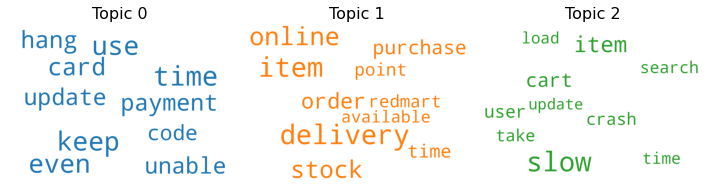

In [96]:
# Wordcloud of Top N words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=stops,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = neg_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Among the key topics derived from the **negative reviews**, the following **customers' pain points** are identified:

* Topic 0: **Payment/ credit card issues**
* Topic 1:  **Out-of-stock (OOS)/ No delivery slot**
* Topic 2:  **Bugs/ Laggy interface**

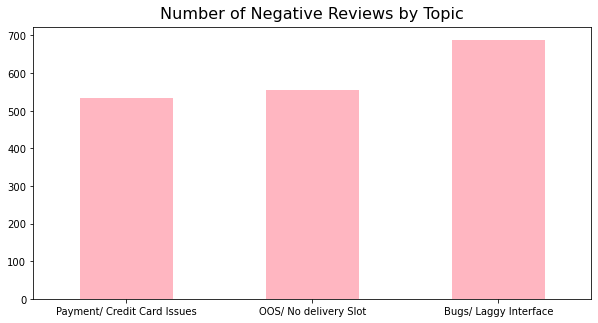

In [97]:
plt.figure(figsize=(10, 5))
neg_df_dominant_topic['Dominant_Topic'].value_counts().sort_index().plot(kind='bar', color='lightpink')
plt.xticks(np.arange(3), labels=['Payment/ Credit Card Issues', 'OOS/ No delivery Slot', 'Bugs/ Laggy Interface'], rotation=0)
plt.title('Number of Negative Reviews by Topic', fontsize=16, y=1.01);

Of thte 3 topics customer pain points, Bugs/ Laggy Interface is the most prominant one.

Let's also take a look at the reviews for each pain point identified.

In [98]:
df_negative = df[df['neg_review'] == 1]
df_negative.reset_index(drop=True, inplace=True)

In [99]:
neg_df_dominant_topic['review']= df_negative['review']

### Pain Point 1: Payment/ Credit Card Issues

In [100]:
# negative reviews on the topic 'Payment/ Credit Card Issues'
pd.set_option('display.max_colwidth', None)
neg_df_dominant_topic[neg_df_dominant_topic['Dominant_Topic'] == 0.0][['review']].head(10)

,review
0,Not a good experience for first timer. Login and sign up was not a problem. What i did not like at all was after entering all details it prompted me no delivery dates are available which should have been the first step instead of last
6,"Encountered payment not successful error, credit card not charged. Pls check it out"
22,"App checkout was so slow. When I was trying to pay my bank gave an error with an OTP which turn made my transaction unsuccessful. And to make matters worse, my cart became empty."
30,Cannot use the scan n go
33,please extend the payment method like pay now and paylah as well. Thank you.
40,"Terrible app with bugs! Contact us is a web view which cannot upload photos as intended. Long waiting time and no feedback that the form is under server processing. Password management is highly insecured. Lost confidence to input credit card information. Multiple halt and hungs where I am out of the app to my app launchpad on Android 8. Poor Usability, User Journey Thinking and User Experience! These are reasons now not to award any stars if possi le to such crappy app!"
41,"The transaction could not go through citing to me that my ocbc credit card had expired. I uninstalled and reinstalled the app, deleted and added the credit card details only to be told the same error message. I tried a credit card with another bank, dbs, and it worked. I even called ocbc to verify the status of the card abd the cso reassured me that there was no issue. A huge inconveniece indeed!"
44,"The old apps used to work fine. After some upgrade, it was horrible. The payment and checkout keep registering unsuccessful transaction and ask to check for card expiry. It is your apps problem NTUC FairOn ...nothing to do with the bank credit card. When the app is doing fine, leave it - don't be too clever to change it. BTW, the new app is not user friendly because you cannot re-order again from your last order...disappointing!"
45,Tried making a purchase but facing buggy experience at the checkout page. Key in all my details but the Pay button disappears after verifying my delivery address. Really disappointed with the app. Update: managed to purchased 4 XXL size diapers using laptop web browser but received 4 L size diapers. You screwed up my first purchase! What the hell is wrong with fairprice online?
47,"frustrating, not user friendly, promotion code when applied keep giving error message, feedback template could not upload image file despite pressing the + sign. Called helpdesk, lucky that the operator was helpful who email me so that i can do a reply and attach the image file of the error message. But still waiting for response probably by then the promotion code expired. Very disappointed!"


Among the negative reviews on **Payment/ Credit Card Issues**, some of the key issues faced by customers include:

* Error during payment
* App stating that credit card is expired (when it is not)
* Error when using promotion codes

### Pain Point 2: Out-of-Stock/ No Delivery Slot

In [101]:
neg_df_dominant_topic[neg_df_dominant_topic['Dominant_Topic'] == 1.0][['review']].head(10)

,review
1,"One of the lousiest app! Tried using it several times since May 20 but never once did I complete the transaction. Reason: 1. In May 20 it always say ""no slot"". By the time there was slot, many items in my cart had become ""no stock"". No point for me to pay the delivery fee for a ""half-filled cart"". 2. In Jul 20 I tried to use the app again to utilise a promo code. But it kept saying ""promo code error"". When the code finally got accepted, some items became ""no stock"" again. It's so irritating!"
4,The app would have gotten a 4 stars from me except the fact that it is not thought thru well enough as all purchases thru this app are not eligible for the bonus points that consumers need for redemption. It is quite a disappointment that such a basic feature is not included into the app.
5,"All the complaints by other users also happened to me. I even email to them but nothing rectified. I think I have to uninstall this app totally and stop ordering from them online. Think I can't even give them a star, but I can't post when I didn't click 1 star .Waste a lot of my time locking in and out, items out of stock, no time slot available and can't even checkout."
7,Always get changes to my order. Items out of stock after order is placed. Free delivery but charge service and packing. So it is not really free. One item on sale in the app but charged full amount.
9,"Looks like it's not working. Anytime l login, it shows slots are full. How come no slot available anytime time of the day or night? Extremely disappointed"
10,Ridiculous fees with 1001 restrictions! Use at your own risk!A lot of items out of stock but the nearby physical store has the stock!
12,Useless online grocery app. Poor product range and availablity. Most things are out of stock.
14,Purchases made through your FairPrice app will not get to earn Link! Points. Very unfair and highly disappointed at your policies. Will delete this app henceforth.
15,Why no linkpoint issuance or assoc. Still ntuc member and doing shopping on ntuc platform. whats the point of having an online platform yet you discourage people to do online n go offline shoppi g to gain the points?
16,Unstable. Cannot view order on the day of delivery so cannot check delivery stuff.


The negative reviews on **Out-of-stock/ No delivery slot** issues mainly point to frustrated customers no being able to get delivery slots, or the items they want are out-of-stock by the time a delivery slot is made available.

### Pain Point 3: Laggy Interface

In [102]:
neg_df_dominant_topic[neg_df_dominant_topic['Dominant_Topic'] == 2.0][['review']].head(10)

,review
2,Lousy app. Cannot find most items using brand name. Now they change the use of label scanning in app which totally disable the label function when store not detected. Slow and unstable. Any online grocery app now is far better.
3,NEW : GETS BETTER AND BETTER - MY LISTS DON'T WORK NOW - how to shop? OLD: this app has improved significantly over the last 2+year. It still is missing the AI to anticipate what you want to order and to. give quick access to your shopping list and. allow you to sort and filter your favourites / shopping list ... This makes the app. very inefficient and slow to shop in.. And product wise - consistently rotten fruit and vegetables
8,Very lousy experience. Not able to change on self collect even the help guide say otherwise. Not user friendly. Hard to navigate
11,Rubbish app. Added 20 over items. All disappear from cart when about to pay. Big enterprise earning so much profit a year cannot afford to test and remove bugs from app.
13,Some items keep disappearing from the cart when i tried to pay!! What's happening???
17,The app is very very slow and takes a very long time to load. Alot of the items are out of stock too. The delivery time is also unavailable. I have been trying to load my cart for more than half an hour now and it's still not loading until now. ( not my network as all the other apps works perfectly fine)
18,"At first, delivered items on the last order still appeared in the cart. After removing them manually item by item, they still appeared after opened app from another phone. Then all reappeared on my phone after I clicked on cart. fter I spent 30 mins putting itens into cart, all items disappeared! It seems items which should be removed aren't removed and items which are newly added are removed. Wasted my time and effort!!!"
19,"The app is getting worse, it will show items out of stock immediately after i selected the item. Now I can't even checkout, it will tell me I have an invalid cart. I was patient enough to clear everything in my cart and add back the items but it still failed."
20,"Techical bugs need to be fixed, e.g. 'invalid cart'. Should not auto-remove our item if it's out of stock. Why not just disable the check-out function for the item while maintaining it at the cart? I have been using this app for more than 3 years. Before the CB, things work fine. During the CB, i can see that other platforms are catching up and improving their app, now working much better than this app. FairPrice Online instead is lagging behind and losing the #1 choice reputation."
25,"I don't know how this app was on normal times, but in this high demand time, exactly at midnight the cart never loads, and after every few minutes it says my cart is empty. Failed Load Test Miserably"


Some of the negative reviews pertaining to **Bugs/ laggy interface** touch on:

* Takes very slow to load shopping cart
* Items disappearing from shopping cart/ items remaining in shopping cart after order
* Unable to search items by brand

### Visualisation of Topic Cluster using pyLDAvis

In [103]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
neg_vis = pyLDAvis.gensim.prepare(neg_lda_model, neg_corpus, dictionary=neg_lda_model.id2word, sort_topics=False)
pyLDAvis.save_html(neg_vis, './output/neg_lda.html')

<img src="./images/topic modelling_negative reviews.png" width="700" align="left">

This is a static snap shot. Please refer to the interactive version of the LDA visualisation **neg_lda.html** in the **output** folder.

It can be seen that the 3 topics identified are distinct clusters without overlap. 

# 4. Conclusion & Recommendation

### 1. Text classification to identify negative reviews for prompt follow up

Based on evaluation of the variou classification models built, the production model is a **Voting Classifier** consisting of an ensemble of a **Multinomial NB model and Logistic Regression model**, with features extracted using the **TfidfVectorizer**. 

Given its **relatively high accuracy (0.88) and recall (0.89) on the test data**, we can conclude that the model generalises well on unseen data, and can be used to **identify negative reviews** for NTUC Fairprice mobile app, which can **allow for prompt follow up and service recovery**.


### 2. Topic modelling to identify customer pain points for improvement opportunities

Based the **topic modelling using LDA**, the 3 main customer pain points identified are:

1. **Bugs/ Laggy interface**
2. **Out-of-stock/ No delivery slot**
3. **Payment/ Credit card issues**

Based on these pain points on the user journey, it can be seen that **poor customer experience leans towards the later part of the user journey**, leading to **abandon carts** and **loss of revenue**.

*User Journey Mapping*

<img src="./images/user journey.png" width="800" align="left">

The NTUC Fairprice mobile app team can look into ways to improve customer experience, by prioritising 2 aspects:

1. App development team - To focus on ensuring that app is not laggy in times of high loads, and rectify issues such as items disappearing from carts and payment errors.

2. Operations & supply chain team - To focus on inventory management, and improve delivery capacity, either through expanding delivery team or engaging third party logistics support.
